<div align="center">

# MScFE 622 STOCHASTIC MODELING

## Group Work Project #3:  Risk-Aware Portfolio Selection

### Group 10341

</div>


*[Link to Instruction](https://drive.google.com/file/d/1nkDuECQ5YKEmtrtBNZX15AwP8BfK0JMJ/view?usp=share_link)*

# Step 1 - 4

## Step 2: Portfolio Selection as a Multi-Armed Bandit Problem Pseudocode

So we are going to expand the original model 1 from the Huo paper, we will incorporate the essential elements while respectng the project constraints

```python
Algorithm: Risk-Aware Multi-Armed Bandit Portfolio Selection

**Inputs**
    - δ = historical window size  
    - N = INvestments horizon
    - K = number of asset
    - Y = CVaR confidence level
    - λ = risk-reward trade off parameter

// Step 1: Data Collection and Preprocessing    
FUNCTION CollectHistoricalData():     
    // Get historical price data for all available assets     
    prices = GET_HISTORICAL_PRICES(Start_date, end_date)

    // Calculate log returns: R_i,t = log(P_i,t+1 / P_i,t)
    returns = CALCULATE_LOG_RETURNS(prices)

    // Histroical returns for the δ period before investment
    H = returns[1:δ, :]  // δ x M matrix where M = total assets

    RETURN H

// Step 2: Simplified Asset Filtering
FUNCTION FIlterAssets(H, K):
    // We are using a  simplified filtering method based on the given paper stock selection

    // The parer uses 30 stocks: 15 financial and 15 no-financial
    financial_stocks = ["JPM", "WFC", "BAC", "C", "GS", "USB", "MS", "KEY",
                        "PNC", "COF", "AXP", "PRU", "SCHW", "BBT", "STI"]
    non_financial_stocks = ["KR", "PFE", "XOM", "WMT", "DAL", "CSCO", "HCP",
                            "EQIX", "DUK", "NFLX", "GE", "APA", "F", "REGN", "CMS"]

    // Getting indices of above stocks in our dataset
    selected_indices = GET_INDICES_OF_STOCKS(financial_stocks + non_financial_stocks)

    // Extracting returns
    H_Selected = H[:, selected_indices]

    return H_Selected, selected_indices

// step 3: UCB1 Portfolio Construction (Exploration-Exploitation)
FUNCTION ConstructUBPortfolio(t, historical_returns, observed_returns):
    // Initialize: play each asset  once in  the first K rounds
    IF r ≤ K:
        RETURN ONE_HOT_VECTOR(t)

    // Empirical mean returns
    μ = CALCULATE_MEAN_RETURNS(historical_returns, observed_returns)

    // getting number of times each asset was selected
    T = COUNT_SELECTIONS(observed_returns)

    // UCB1 formula: argmax[μ_i(t) + sqrt(2*log(t)/T_i(t-1))]
    ucb_scores = μ + SQRT(2 * LOG(t) / T)

    // Return portfolio with 100% allocation to the best UCB asset
    best_asset = ARGMAX(ucb_scores)
    Return ONE_HOT_VECTOR(best_asset)

// Step 4: Risk-aware Portfolio Construction (CVaR Minimization)
FUNCTION ConstructRiskAwarePortfolio(γ, historical_returns, obsrved_returns):
    // Performance function approximation from equation (2.3)
    // F̃_γ(u, α, t) = α + (1/γδ) * Σ[(-u^T H_s - α)_+] + (1/γ(t-1)) * Σ[(-u^T R_s - α)_+]
    
    // Define optimization problem
    // minimize_{u∈W, α∈R} F̃_γ(u, α, t)
    // where W = {u ∈ R+^K: u^T 1 = 1} (long-only, self-financed portfolios)
    
    // This is a convex optimization problem per Theorem 2.6
    
    // Solve using convex optimization techniques
    (u*, α*) = SOLVE_CONVEX_OPTIMIZATION(
        objective = PERFORMANCE_FUNCTION(γ, historical_returns, observed_returns),
        constraints = [u ≥ 0, SUM(u) = 1]
    )
    
    RETURN u*

// step 5: Combined Porfolio Strategy
FUNCTION ConstructCombinedPortfolio(t, γ, λ, historical_returns, observed_returns):
    // Get the UCB portfolio (single-asset selection)
    ω_M = ConstructUCBPortfolio(t, historical_returns, observed_returns)
    
    // Get the risk-aware portfolio (CVaR minimization)
    ω_C = ConstructRiskAwarePortfolio(γ, historical_returns, observed_returns)
    
    // Combine according to equation (2.5): ω* = λω_M + (1-λ)ω_C
    ω_star = λ * ω_M + (1 - λ) * ω_C
    
    // Ensure portfolio weights sum to 1 (due to potential floating-point errors)
    ω_star = ω_star / SUM(ω_star)
    
    RETURN ω_star

// Step 6: Main Portfolio Selection Algorithm
FUNCTION RiskAwarePortfolioSelection(δ, N, K, γ, λ):
    // 1. Receice historical returns
    H = COllectHistoricalData()

    // 2. Filter to select a basket of K assets
    H_selected, selected_indices = FilterAssets(H, K)

    // Initialize storage for observed returns
    observed_returns = EMPTY_MATRIX(0, k)

    // 3. Iterate through Investent horizon
    FOR t = 1 TO N DO:
        // 3.1 Choose portfolio using combined strategy
        ω_t = ConstructCombinedPortfolio(t, γ, λ, H_selected, observed_returns)
        
        // 3.2 Get actual returns for this period (R_t)
        R_t = GET_NEXT_RETURNS(selected_indices)
        
        // 3.3 Calculate portfolio return (reward)
        reward = DOT_PRODUCT(ω_t, R_t)
        
        // 3.4 Update observed returns for future iterations
        observed_returns = APPEND(observed_returns, R_t)
        
        // 3.5 Record results for analysis
        RECORD_RESULTS(t, ω_t, reward)
    END FOR

    // 4. Cumulative performance metrics
    cumulativee_return = CALCULATE_CUMULATIVE_RETURN()
    regret = CALCULATE_REGRET()

    RETURN cumulative_return, regret, ALL_RESULTS  




```




 ## Step 3: Data Collection

### 3a Financial  Data

In [2]:
!pip install alpha_vantage
!pip install yfinance

In [12]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from alpha_vantage.timeseries import TimeSeries
import random
from  datetime import datetime
import warnings
import scipy
warnings.filterwarnings('ignore')

#  Alpha Vantage APi configuration
API_KEY = "ZBN93B5SHT278SC1"



def get_stock_data(tickers, start_date, end_date, delay=20):
    # download historical price data for specified stock tickers
    ts = TimeSeries(key=API_KEY, output_format="pandas")

    # initialize empty Dataframe to store results
    all_data = pd.DataFrame()

    for i, ticker in enumerate(tickers):
        try:
            print(f"  [{i+1}/{len(tickers)}] Downloading {ticker}...", end="", flush=True)

            # Get daily adjusted data
            data = ts.get_daily(symbol=ticker, outputsize="full")[0]

            # Convert index to datetime and sort
            data.index = pd.to_datetime(data.index)
            data = data.sort_index()

            # Select only adjusted close price
            adj_close = data['4. close'].copy()
            adj_close.name = ticker

            # Filter by date range
            adj_close = adj_close.loc[start_date:end_date]

            # Add to our main DataFrame
            all_data = pd.concat([all_data, adj_close], axis=1)

            print(f" ✓ ({len(adj_close)} days)")

            # Apply rate limiting (Alpha Vantage free tier: 5 calls/minute)
            if i < len(tickers) - 1:
                time.sleep(delay)

        except Exception as e:
            print(f" ✗ (error: {str(e)})")
            # Wait longer if we encounter an error
            time.sleep(15)

    print(f"Successfully downloaded data for {len(all_data.columns)} out of {len(tickers)} tickers.")
    return all_data

def clean_and_calculate_returns(price_data):
    # Checking for missing values
    missing_before = price_data.isna().sum().sum()
    print(f"Found {missing_before} missing values in raw price data.")

    # Forward fill missing values
    price_data_cleaned = price_data.ffill()

    # Calculating log returns
    log_returns = np.log(price_data_cleaned / price_data_cleaned.shift(1)).dropna()

    # Verify return calculations
    print(f"Calculated log returns for {len(log_returns)} trading days.")
    print(f"Average daily return: {log_returns.mean().mean():.6f}")
    print(f"Annualized volatility (252 trading days): {log_returns.std().mean() * np.sqrt(252):.4f}")

    return log_returns

```python
After encountering below error
[13/15] Downloading BBT... ✗ (error: Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY.)
[14/15] Downloading STI... ✓ (0 days)

-   I substistuted STI and BBT as follow
- For BBT,- MTB (M&T Bank)
- For STI, - BK (Bank of New York Mellon)
```

In [4]:
# Financial tickers
financial_tickers = ["JPM", "BAC", "C", "GS", "USB", "MS", "KEY",
                     "PNC", "COF", "AXP", "PRU", "SCHW", "BK", "MTB", "WFC"]

# Set the date range (Sep-Oct 2008)
start_date = "2008-09-01"
end_date = "2008-10-31"

# Step 3a: Member A - financial institution data
print("="*50)
print("STEP 3a: Member A - Financial Institution Data Collection")
print("="*50)
financial_prices = get_stock_data(financial_tickers, start_date, end_date)
financial_returns = clean_and_calculate_returns(financial_prices)

STEP 3a: Member A - Financial Institution Data Collection
  [1/15] Downloading JPM... ✓ (44 days)
  [2/15] Downloading BAC... ✓ (44 days)
  [3/15] Downloading C... ✓ (44 days)
  [4/15] Downloading GS... ✓ (44 days)
  [5/15] Downloading USB... ✓ (44 days)
  [6/15] Downloading MS... ✓ (44 days)
  [7/15] Downloading KEY... ✓ (44 days)
  [8/15] Downloading PNC... ✓ (44 days)
  [9/15] Downloading COF... ✓ (44 days)
  [10/15] Downloading AXP... ✓ (44 days)
  [11/15] Downloading PRU... ✓ (44 days)
  [12/15] Downloading SCHW... ✓ (44 days)
  [13/15] Downloading BK... ✓ (44 days)
  [14/15] Downloading MTB... ✓ (44 days)
  [15/15] Downloading WFC... ✓ (44 days)
Successfully downloaded data for 15 out of 15 tickers.
Found 0 missing values in raw price data.
Calculated log returns for 43 trading days.
Average daily return: -0.005875
Annualized volatility (252 trading days): 1.3608


In [5]:
financial_prices.head()

## Saving for future use
financial_prices.to_excel("Financial_Prices.xlsx")

In [6]:
financial_returns.head()

## Saving for future use

financial_returns.to_excel("Financial_Returns.xlsx")

### 3b. Non-Financial Data

Also for the Non-financial, we encountered error
```python
[7/15] Downloading HCP... ✓ (0 days)
```
HCP didn't not return  any data due to  delisting in 2017 so I replace it with VTR (Ventas, Inc.) — another large healthcare REIT active in 2008

In [27]:
non_financial_tickers = ["KR", "PFE", "XOM", "WMT", "DAL", "CSCO", "VTR",
                         "EQIX", "DUK", "NFLX", "GE", "APA", "F", "REGN", "CMS"]

print("\n" + "="*50)
print("STEP 3b: Member B - Non-Financial Institution Data Collection")
print("="*50)
non_financial_prices = get_stock_data(
    non_financial_tickers,
    start_date,
    end_date,
    delay=13
)
non_financial_returns = clean_and_calculate_returns(non_financial_prices)


STEP 3b: Member B - Non-Financial Institution Data Collection
  [1/15] Downloading KR... ✓ (44 days)
  [2/15] Downloading PFE... ✓ (44 days)
  [3/15] Downloading XOM... ✓ (44 days)
  [4/15] Downloading WMT... ✓ (44 days)
  [5/15] Downloading DAL... ✓ (44 days)
  [6/15] Downloading CSCO... ✓ (44 days)
  [7/15] Downloading VTR... ✓ (44 days)
  [8/15] Downloading EQIX... ✓ (44 days)
  [9/15] Downloading DUK... ✓ (44 days)
  [10/15] Downloading NFLX... ✓ (44 days)
  [11/15] Downloading GE... ✓ (44 days)
  [12/15] Downloading APA... ✓ (44 days)
  [13/15] Downloading F... ✓ (44 days)
  [14/15] Downloading REGN... ✓ (44 days)
  [15/15] Downloading CMS... ✓ (44 days)
Successfully downloaded data for 15 out of 15 tickers.
Found 0 missing values in raw price data.
Calculated log returns for 43 trading days.
Average daily return: -0.004308
Annualized volatility (252 trading days): 0.8739


In [28]:
## Saving for future use
non_financial_prices.to_excel("Non_Financial_Prices.xlsx")

In [30]:
non_financial_prices.head()

,KR,PFE,XOM,WMT,DAL,CSCO,VTR,EQIX,DUK,NFLX,GE,APA,F,REGN,CMS
2008-09-02 00:00:00,27.80,19.17,77.32,59.65,9.17,23.75,45.19,80.95,17.34,30.84,28.53,106.34,4.51,20.58,13.61
2008-09-03 00:00:00,27.79,19.20,78.02,59.79,9.11,23.31,45.65,80.15,17.12,30.91,28.57,107.48,4.57,21.80,13.45
2008-09-04 00:00:00,27.25,18.67,76.14,59.78,8.96,22.28,43.87,77.50,17.29,29.87,27.70,110.03,4.39,20.38,13.47
2008-09-05 00:00:00,26.87,18.51,75.62,60.74,8.81,22.26,43.64,77.49,17.31,29.66,27.88,111.43,4.41,19.07,13.34
2008-09-08 00:00:00,27.30,19.14,76.77,62.00,8.59,23.37,44.80,77.51,17.87,30.15,29.09,109.77,4.55,18.90,13.75


In [34]:
## Saving for future use
non_financial_returns.to_excel("Non_Financial_Returns.xlsx")

In [32]:
non_financial_returns.head()

,KR,PFE,XOM,WMT,DAL,CSCO,VTR,EQIX,DUK,NFLX,GE,APA,F,REGN,CMS
2008-09-03 00:00:00,-0.000360,0.001564,0.009013,0.002344,-0.006565,-0.018700,0.010128,-0.009932,-0.012769,0.002267,0.001401,0.010663,0.013216,0.057590,-0.011826
2008-09-04 00:00:00,-0.019623,-0.027992,-0.024391,-0.000167,-0.016602,-0.045193,-0.039773,-0.033622,0.009881,-0.034225,-0.030925,0.023448,-0.040184,-0.067356,0.001486
2008-09-05 00:00:00,-0.014043,-0.008607,-0.006853,0.015931,-0.016883,-0.000898,-0.005257,-0.000129,0.001156,-0.007055,0.006477,0.012644,0.004545,-0.066438,-0.009698
2008-09-08 00:00:00,0.015876,0.033469,0.015093,0.020532,-0.025289,0.048662,0.026234,0.000258,0.031839,0.016386,0.042485,-0.015009,0.031253,-0.008954,0.030272
2008-09-09 00:00:00,0.023530,-0.048163,-0.046799,-0.014132,-0.042813,-0.017264,-0.033363,-0.045261,0.012789,-0.047895,-0.033913,-0.087732,-0.033523,-0.020311,-0.024293


### 3c Combining the data

In [49]:
##  Member C combines the data into a suitable Python time series data structure.
def combine_datasets(financial_returns, non_financial_returns):

  # Verify both datasets have the same data range
  common_dates = financial_returns.index.intersection(non_financial_returns.index)
  print(f"Found {len(common_dates)} common trading days between datasets.")

  # Combine the datasets
  combined_returns = pd.concat([financial_returns.loc[common_dates], non_financial_returns.loc[common_dates]], axis=1)

  # Verify Combination
  print(f"Combined dataset shape: {combined_returns.shape} (days x stocks)")

  return combined_returns


In [50]:
# Combine the returns
combined_returns = combine_datasets(financial_returns, non_financial_returns)
combined_returns.head()

Found 43 common trading days between datasets.
Combined dataset shape: (43, 30) (days x stocks)


,JPM,BAC,C,GS,USB,MS,KEY,PNC,COF,AXP,...,CSCO,VTR,EQIX,DUK,NFLX,GE,APA,F,REGN,CMS
2008-09-03 00:00:00,0.018298,0.010063,0.025828,0.013757,0.017759,0.020847,0.008692,0.009217,0.016340,0.006868,...,-0.018700,0.010128,-0.009932,-0.012769,0.002267,0.001401,0.010663,0.013216,0.057590,-0.011826
2008-09-04 00:00:00,-0.046388,-0.074295,-0.069139,-0.040857,-0.040253,-0.044366,-0.064171,-0.018656,-0.052377,-0.054244,...,-0.045193,-0.039773,-0.033622,0.009881,-0.034225,-0.030925,0.023448,-0.040184,-0.067356,0.001486
2008-09-05 00:00:00,0.043614,0.051898,0.041215,0.014438,0.033859,0.024971,0.084421,0.020947,0.031352,0.016635,...,-0.000898,-0.005257,-0.000129,0.001156,-0.007055,0.006477,0.012644,0.004545,-0.066438,-0.009698
2008-09-08 00:00:00,0.048068,0.074706,0.063489,0.038987,0.035997,0.045145,0.057672,0.032968,0.086098,0.028030,...,0.048662,0.026234,0.000258,0.031839,0.016386,0.042485,-0.015009,0.031253,-0.008954,0.030272
2008-09-09 00:00:00,-0.051357,-0.065749,-0.073502,-0.048652,-0.056985,-0.068630,-0.043890,-0.052542,-0.068583,-0.057914,...,-0.017264,-0.033363,-0.045261,0.012789,-0.047895,-0.033913,-0.087732,-0.033523,-0.020311,-0.024293


In [51]:
## Saving for future use
combined_returns.to_excel("Combined_Returns.xlsx")

## Step 4:  Correlation Matrix Analysis and Visualization

For this step we will load the data that was  processed and saved instead of re-rening step 3 due to API KEy limits

In [3]:
import pandas as pd
combined_returns = pd.read_excel("https://raw.githubusercontent.com/JackronyK/MSC-FE/main/Group%20Work/GW%203/Data/Combined_Returns.xlsx", index_col=0)
combined_returns.index = pd.to_datetime(combined_returns.index)
combined_returns.head()




,JPM,BAC,C,GS,USB,MS,KEY,PNC,COF,AXP,...,CSCO,VTR,EQIX,DUK,NFLX,GE,APA,F,REGN,CMS
2008-09-03,0.018298,0.010063,0.025828,0.013757,0.017759,0.020847,0.008692,0.009217,0.016340,0.006868,...,-0.018700,0.010128,-0.009932,-0.012769,0.002267,0.001401,0.010663,0.013216,0.057590,-0.011826
2008-09-04,-0.046388,-0.074295,-0.069139,-0.040857,-0.040253,-0.044366,-0.064171,-0.018656,-0.052377,-0.054244,...,-0.045193,-0.039773,-0.033622,0.009881,-0.034225,-0.030925,0.023448,-0.040184,-0.067356,0.001486
2008-09-05,0.043614,0.051898,0.041215,0.014438,0.033859,0.024971,0.084421,0.020947,0.031352,0.016635,...,-0.000898,-0.005257,-0.000129,0.001156,-0.007055,0.006477,0.012644,0.004545,-0.066438,-0.009698
2008-09-08,0.048068,0.074706,0.063489,0.038987,0.035997,0.045145,0.057672,0.032968,0.086098,0.028030,...,0.048662,0.026234,0.000258,0.031839,0.016386,0.042485,-0.015009,0.031253,-0.008954,0.030272
2008-09-09,-0.051357,-0.065749,-0.073502,-0.048652,-0.056985,-0.068630,-0.043890,-0.052542,-0.068583,-0.057914,...,-0.017264,-0.033363,-0.045261,0.012789,-0.047895,-0.033913,-0.087732,-0.033523,-0.020311,-0.024293


In [8]:
from scipy.cluster import hierarchy

def compute_correlation_matrix(log_returns):

    # Calculate correlation matrix
    corr_matrix = log_returns.corr()
    
    print(f"Correlation matrix computed. Shape: {corr_matrix.shape}")
    print(f"Mean correlation: {corr_matrix.mean().mean():.4f}")
    print(f"Median correlation: {corr_matrix.median().median():.4f}")
    print(f"Range: [{corr_matrix.min().min():.4f}, {corr_matrix.max().max():.4f}]")
    
    return corr_matrix


In [9]:
# Compute correlation matrix
corr_matrix = compute_correlation_matrix(combined_returns)


Correlation matrix computed. Shape: (30, 30)
Mean correlation: 0.6112
Median correlation: 0.6173
Range: [0.1627, 1.0000]


In [6]:
corr_matrix

,JPM,BAC,C,GS,USB,MS,KEY,PNC,COF,AXP,...,CSCO,VTR,EQIX,DUK,NFLX,GE,APA,F,REGN,CMS
JPM,1.000000,0.836628,0.800360,0.482464,0.848287,0.381572,0.558129,0.829001,0.697656,0.700822,...,0.685972,0.765999,0.638464,0.331101,0.544118,0.769434,0.516532,0.477588,0.579142,0.553977
BAC,0.836628,1.000000,0.886458,0.657504,0.771470,0.599664,0.748574,0.660556,0.779871,0.762376,...,0.716562,0.691992,0.623594,0.356914,0.562813,0.697756,0.588297,0.628704,0.544827,0.635196
C,0.800360,0.886458,1.000000,0.624545,0.727665,0.590993,0.725752,0.625113,0.788652,0.747068,...,0.642343,0.704727,0.606853,0.365379,0.478026,0.692055,0.528288,0.527288,0.531051,0.593754
GS,0.482464,0.657504,0.624545,1.000000,0.383932,0.820813,0.651462,0.221743,0.485177,0.698842,...,0.599891,0.472083,0.575359,0.390884,0.232750,0.340202,0.590885,0.487291,0.456654,0.586067
USB,0.848287,0.771470,0.727665,0.383932,1.000000,0.416094,0.527630,0.845377,0.777203,0.681729,...,0.689160,0.764515,0.612241,0.432955,0.499516,0.675418,0.564733,0.582185,0.579457,0.562219
MS,0.381572,0.599664,0.590993,0.820813,0.416094,1.000000,0.591144,0.227390,0.532105,0.730322,...,0.632492,0.538739,0.570859,0.549742,0.330463,0.318993,0.673804,0.594319,0.544490,0.651847
KEY,0.558129,0.748574,0.725752,0.651462,0.527630,0.591144,1.000000,0.472171,0.673831,0.719763,...,0.508387,0.509077,0.426266,0.224434,0.162700,0.526500,0.444505,0.587097,0.409700,0.487160
PNC,0.829001,0.660556,0.625113,0.221743,0.845377,0.227390,0.472171,1.000000,0.641732,0.603223,...,0.590650,0.710047,0.539418,0.404247,0.427618,0.720629,0.430480,0.522459,0.483292,0.436664
COF,0.697656,0.779871,0.788652,0.485177,0.777203,0.532105,0.673831,0.641732,1.000000,0.810740,...,0.759298,0.779019,0.634225,0.454635,0.526940,0.673073,0.633780,0.640537,0.651440,0.658685
AXP,0.700822,0.762376,0.747068,0.698842,0.681729,0.730322,0.719763,0.603223,0.810740,1.000000,...,0.747310,0.803991,0.720820,0.520932,0.387697,0.639900,0.733419,0.650227,0.667617,0.648746


In [10]:
def plot_correlation_heatmap(corr_matrix, title, figsize=(14, 12), sort_method="hierarchical"):

    # Create a copy to avoid modifying the original
    sorted_corr = corr_matrix.copy()
    
    # Apply sorting if requested
    if sort_method == "hierarchical":
        # Hierarchical clustering to sort the matrix
        corr_linkage = hierarchy.linkage(
            scipy.spatial.distance.pdist(corr_matrix), 
            method='ward'
        )
        dendro_idx = hierarchy.leaves_list(corr_linkage)
        sorted_corr = corr_matrix.iloc[dendro_idx, dendro_idx]
        print("Applied hierarchical clustering to sort correlation matrix.")
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(sorted_corr, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Draw the heatmap with the mask
    sns.heatmap(
        sorted_corr, 
        mask=mask,
        cmap='coolwarm', 
        annot=False, 
        fmt=".2f",
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .7},
        vmin=-1,
        vmax=1
    )
    
    # Add labels and title
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    return sorted_corr


Applied hierarchical clustering to sort correlation matrix.


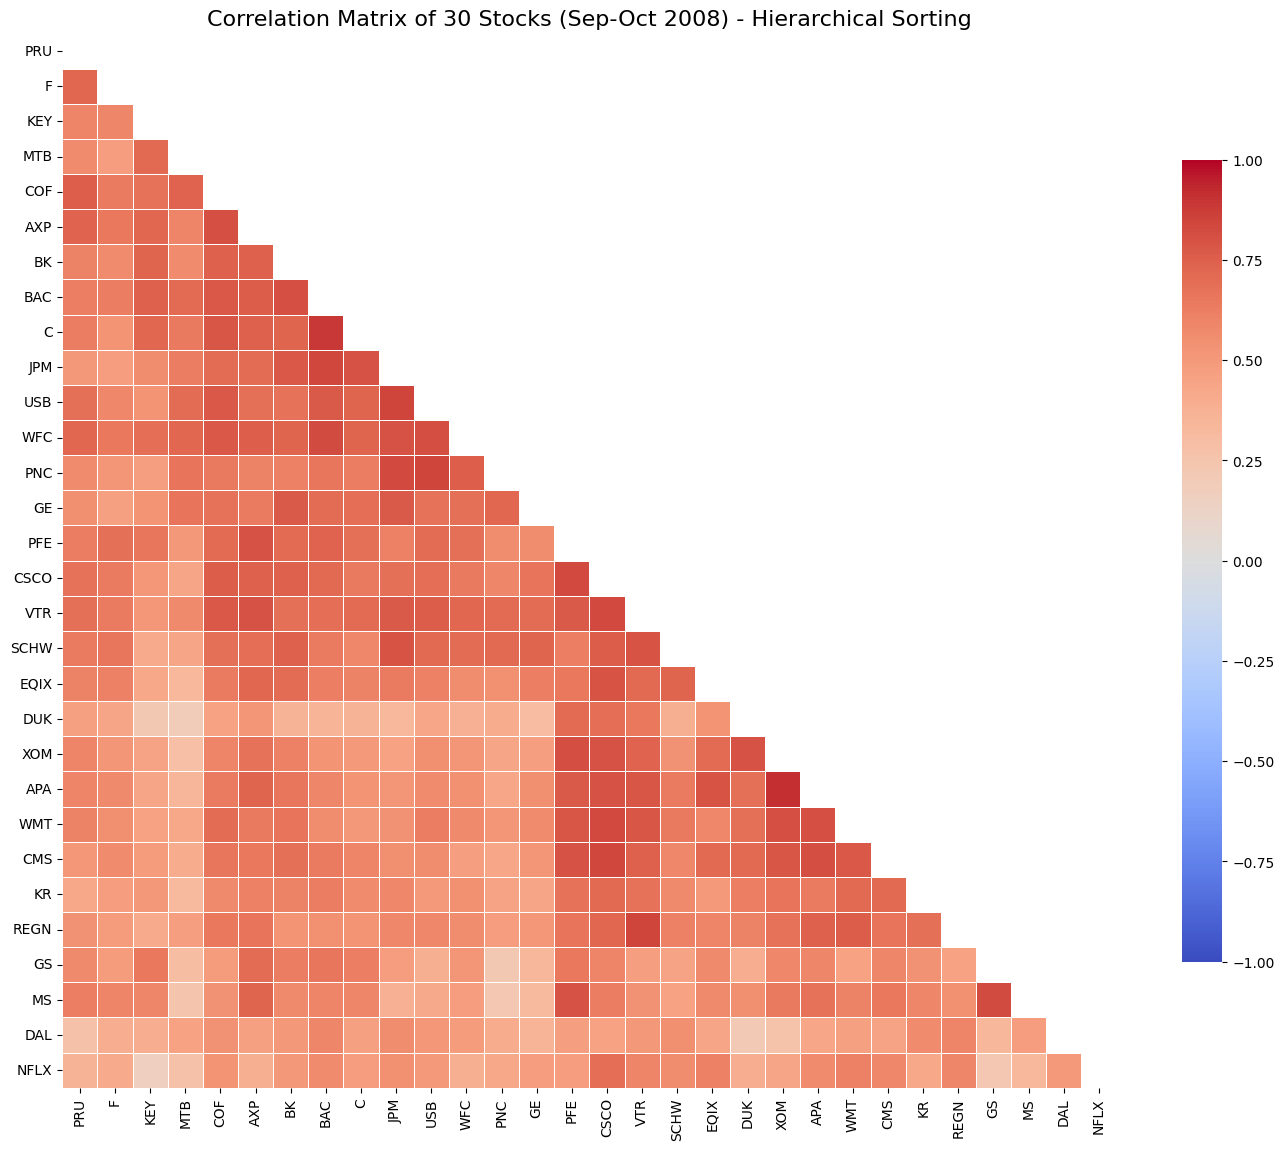

In [14]:
# Plot heatmap with hierarchical sorting
sorted_corr = plot_correlation_heatmap(
    corr_matrix, 
    "Correlation Matrix of 30 Stocks (Sep-Oct 2008) - Hierarchical Sorting",
    sort_method="hierarchical"
)



# Step 5 -8

# Step 9 - 11